In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
using DifferentialEquations, PhasorNetworks, Lux, NNlib, Zygote, ComponentArrays, Optimisers, OneHotArrays, JLD2
using Plots, QuadGK
using MLUtils: DataLoader
using Random: Xoshiro
using ChainRulesCore: ignore_derivatives
using Statistics: mean

In [3]:
using ChainRulesCore: ignore_derivatives

In [4]:
using Base: @kwdef

# Load the dataset

In [5]:
include("pixel_data.jl")

interpolate_roc (generic function with 1 method)

In [6]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 128    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [7]:
args = Args(batchsize = 128)

Args(0.0003, 128, 10, false)

In [8]:
data_dir = "pixel_data/"

"pixel_data/"

In [9]:
file_pairs = get_dataset(data_dir)

10-element Vector{Tuple{String, String}}:
 ("pixel_data/labels/labels_d17301.parquet", "pixel_data/recon3D/recon3D_d17301.parquet")
 ("pixel_data/labels/labels_d17302.parquet", "pixel_data/recon3D/recon3D_d17302.parquet")
 ("pixel_data/labels/labels_d17303.parquet", "pixel_data/recon3D/recon3D_d17303.parquet")
 ("pixel_data/labels/labels_d17304.parquet", "pixel_data/recon3D/recon3D_d17304.parquet")
 ("pixel_data/labels/labels_d17305.parquet", "pixel_data/recon3D/recon3D_d17305.parquet")
 ("pixel_data/labels/labels_d17306.parquet", "pixel_data/recon3D/recon3D_d17306.parquet")
 ("pixel_data/labels/labels_d17307.parquet", "pixel_data/recon3D/recon3D_d17307.parquet")
 ("pixel_data/labels/labels_d17308.parquet", "pixel_data/recon3D/recon3D_d17308.parquet")
 ("pixel_data/labels/labels_d17309.parquet", "pixel_data/recon3D/recon3D_d17309.parquet")
 ("pixel_data/labels/labels_d17310.parquet", "pixel_data/recon3D/recon3D_d17310.parquet")

In [10]:
q, ylocal, pt = get_samples(file_pairs[1:2])

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [11]:
ylimits = extrema(ylocal) .* 2.0

(-16.1073, 16.3671)

In [12]:
q_test, ylocal_test, pt_test = get_samples(file_pairs[3:3]);

In [13]:
q |> size

(20, 13, 21, 99991)

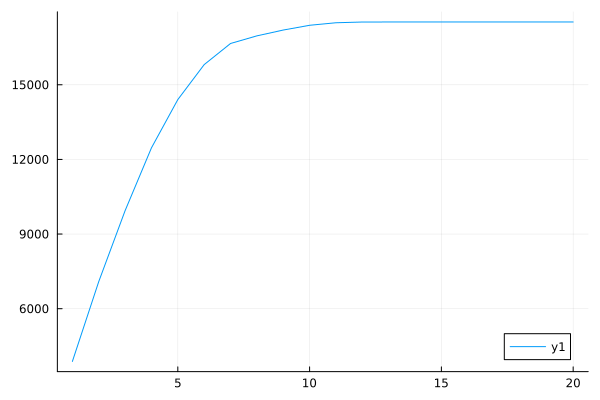

In [14]:
plot(sum(q[:,:,:,128], dims=(2,3)) |> vec)

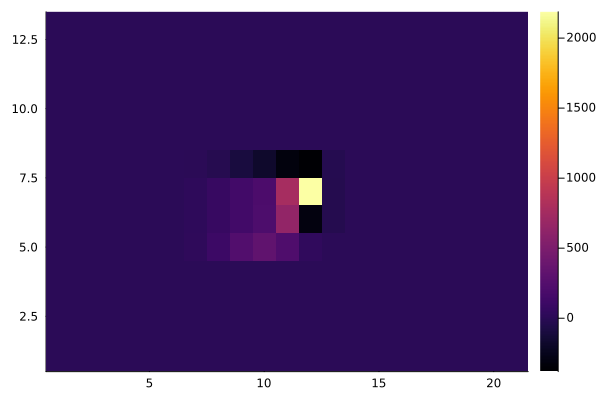

In [15]:
heatmap(q[1,:,:,128])

In [16]:
ylocal |> size

(99991,)

In [17]:
pt |> size

(99991,)

In [18]:
train_loader = DataLoader((q, ylocal, pt), batchsize=args.batchsize)

782-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [19]:
test_loader = DataLoader((q_test, ylocal_test, pt_test), batchsize=args.batchsize)

391-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [20]:
x, xl, y = first(train_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [21]:
#dimensions - (t, y, x, b): (time, y, x, batch)

In [22]:
x |> size

(20, 13, 21, 128)

In [23]:
n_px = size(x, 2) 
n_in = n_px + 1

14

# Set up the model

In [24]:
function process_inputs(x::AbstractArray, x_tms::AbstractVector, y_local::AbstractArray, spk_args::SpikingArgs)
    v_fn = t -> sum(scale_charge(interpolate_2D(t, x_tms, x)), dims=2)[:,1,:]
    y_fn = t -> ylocal_to_current(t, y_local, spk_args)

    x_fn = t -> cat(v_fn(t), reshape(y_fn(t), (1,:)), dims=1)
    return x_fn
end

process_inputs (generic function with 1 method)

In [25]:
sa = SpikingArgs()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [26]:
x_tms = range(start=0.0, stop=1.0, length=size(x, 1)) |> collect

20-element Vector{Float64}:
 0.0
 0.05263157894736842
 0.10526315789473684
 0.15789473684210525
 0.21052631578947367
 0.2631578947368421
 0.3157894736842105
 0.3684210526315789
 0.42105263157894735
 0.47368421052631576
 0.5263157894736842
 0.5789473684210527
 0.631578947368421
 0.6842105263157895
 0.7368421052631579
 0.7894736842105263
 0.8421052631578947
 0.8947368421052632
 0.9473684210526315
 1.0

In [27]:
i_fn = process_inputs(x, x_tms, xl, sa)

#41 (generic function with 1 method)

In [28]:
function sample_current(t, x, i_fn)
    i = sum(i_fn(t), dims=(2))
    i = i[:,1,:]

end

sample_current (generic function with 1 method)

In [29]:
sample_current(0.5, x, i_fn)

14×1 Matrix{Float64}:
   0.0
   0.9312
  12.72694
  83.212
 240.36753999999993
 304.9427600000001
 254.99722000000003
  75.04914
  10.44664
  -0.008279999999999994
   0.0
   0.0
   0.0
  21.045959887366465

In [30]:
#import PhasorNetworks: PhasorODE

In [31]:
# #forward pass
# function (n::PhasorODE)(currents, ps, st)
#     #define the function which updates neurons' potentials
#     function dudt(u, p, t)
#         du_real, _ = n.model(currents(t), p, st)
#         constant = n.spk_args.leakage + 2*pi*im / n.spk_args.t_period
#         du = constant .* u .+ du_real
#         return du
#     end

#     #sample the input & output to determine size of the state
#     i0 = currents(0.0)
#     y0, _ = n.model(i0, ps, st)
#     u0 = zeros(ComplexF32, size(y0))
#     prob = ODEProblem(dudt, u0, n.tspan, ps)
#     soln = solve(prob, n.solver, 
#         adaptive = false, 
#         dt = n.dt, 
#         saveat = n.tspan[1]:n.dt:n.tspan[2],
#         sensealg = n.sensealg,
#         dense=false,
#         )
#     return soln, st
# end

In [32]:
using PhasorNetworks: spiking_offset

In [33]:
ode_fn = Chain(BatchNorm(n_in),
                    x -> tanh.(x),
                    Dense(n_in => 128))

Chain(
    layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
    layer_2 = WrappedFunction{:direct_call}(var"#45#46"()),
    layer_3 = Dense(14 => 128),         # 1_920 parameters
)         # Total: 1_948 parameters,
          #        plus 29 states.

In [91]:
ode_front = Chain(PhasorODE(ode_fn, tspan=(0.0, 1.0), dt=0.01),
                x -> potential_to_phase(Array(x), 1.0, offset=0.25, spk_args=sa))

Chain(
    layer_1 = PhasorODE(
        model = Chain(
            layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
            layer_2 = WrappedFunction{:direct_call}(var"#45#46"()),
            layer_3 = Dense(14 => 128),  # 1_920 parameters
        ),
    ),
    layer_2 = WrappedFunction{:direct_call}(var"#61#62"()),
)         # Total: 1_948 parameters,
          #        plus 29 states.

In [92]:
ode_model = Chain(PhasorODE(ode_fn, tspan=(0.0, 1.0), dt=0.01),
                x -> complex_to_angle(Array(x)[:,:,end]),
                PhasorDenseF32(128 => 3))
                
ode_model = Chain(PhasorODE(ode_fn, tspan=(0.0, 1.0), dt=0.01),
                    x -> solution_to_phase(x, 1.0, offset=spiking_offset(sa), spk_args=sa)[:,:,end],
                    PhasorDenseF32(128 => 3))

Chain(
    layer_1 = PhasorODE(
        model = Chain(
            layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
            layer_2 = WrappedFunction{:direct_call}(var"#45#46"()),
            layer_3 = Dense(14 => 128),  # 1_920 parameters
        ),
    ),
    layer_2 = WrappedFunction{:direct_call}(var"#63#64"()),
    layer_3 = PhasorDenseF32((128, 3)),  # 390 parameters
)         # Total: 2_338 parameters,
          #        plus 29 states.

In [93]:
rng = Xoshiro(42)
ps, st = Lux.setup(rng, ode_model)

((layer_1 = (layer_1 = (scale = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.018712677 0.1624646 … 0.007739915 -0.16842416; -0.13419782 0.1107008 … 0.11776306 -0.17111422; … ; 0.14632118 -0.18586333 … -0.14887094 -0.09080278; 0.081494965 -0.12686923 … 0.11615222 -0.1931912], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])), layer_2 = NamedTuple(), layer_3 = (weight = Float32[0.5993126 0.4167722 … -0.218614 0.34311864; -0.12842335 -0.9040824 … 0.2625846 0.21363495; 0.3049119 -0.8346293 … -0.7711599 1.7686664], bias_real = Float32[1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0])), (layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{true}()), layer_

In [94]:
y_naive, _ = ode_model(i_fn, ps, st);

LoadError: MethodError: no method matching solution_to_phase(::ODESolution{ComplexF32, 3, Vector{Matrix{ComplexF32}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Matrix{ComplexF32}}}, ODEProblem{Matrix{ComplexF32}, Tuple{Float64, Float64}, false, @NamedTuple{layer_1::@NamedTuple{scale::Vector{Float32}, bias::Vector{Float32}}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{weight::Matrix{Float32}, bias::Matrix{Float32}}}, ODEFunction{false, SciMLBase.AutoSpecialize, PhasorNetworks.var"#dudt#142"{PhasorODE{Chain{@NamedTuple{layer_1::BatchNorm{true, true, Float32, typeof(identity), typeof(zeros32), typeof(ones32)}, layer_2::WrappedFunction{:direct_call, var"#45#46"}, layer_3::Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}}, Nothing}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, SciMLSensitivity.InterpolatingAdjoint{0, true, Val{:central}, SciMLSensitivity.ZygoteVJP}, Tuple{Float64, Float64}}, var"#41#44"{var"#40#43"{Vector{Float64}, SpikingArgs}, var"#39#42"{Array{Float64, 4}, Vector{Float64}}}, @NamedTuple{layer_1::@NamedTuple{running_mean::Vector{Float32}, running_var::Vector{Float32}, training::Val{true}}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, OrdinaryDiffEq.InterpolationData{ODEFunction{false, SciMLBase.AutoSpecialize, PhasorNetworks.var"#dudt#142"{PhasorODE{Chain{@NamedTuple{layer_1::BatchNorm{true, true, Float32, typeof(identity), typeof(zeros32), typeof(ones32)}, layer_2::WrappedFunction{:direct_call, var"#45#46"}, layer_3::Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}}, Nothing}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, SciMLSensitivity.InterpolatingAdjoint{0, true, Val{:central}, SciMLSensitivity.ZygoteVJP}, Tuple{Float64, Float64}}, var"#41#44"{var"#40#43"{Vector{Float64}, SpikingArgs}, var"#39#42"{Array{Float64, 4}, Vector{Float64}}}, @NamedTuple{layer_1::@NamedTuple{running_mean::Vector{Float32}, running_var::Vector{Float32}, training::Val{true}}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Vector{Matrix{ComplexF32}}, Vector{Float64}, Vector{Vector{Matrix{ComplexF32}}}, Nothing, OrdinaryDiffEq.Tsit5ConstantCache, Nothing}, SciMLBase.DEStats, Nothing, Nothing, Nothing}, ::Float64; offset::Float64, spk_args::SpikingArgs)

[0mClosest candidates are:
[0m  solution_to_phase(::Union{Function, ODESolution}, [91m::Array[39m; offset, spk_args)
[0m[90m   @[39m [35mPhasorNetworks[39m [90m~/.julia/packages/PhasorNetworks/8rWR9/src/[39m[90m[4mdomains.jl:249[24m[39m


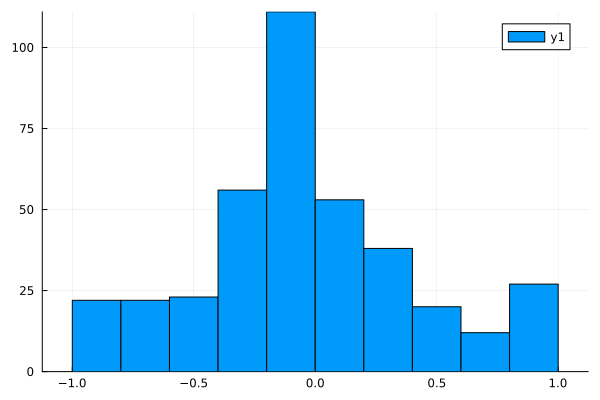

In [ ]:
histogram(y_naive |> vec)

In [ ]:
psa = ComponentArray(ps)

ComponentVector{Float32}(layer_1 = (layer_1 = (scale = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = Float32[], layer_3 = (weight = Float32[-0.018712677 0.1624646 … 0.007739915 -0.16842416; -0.13419782 0.1107008 … 0.11776306 -0.17111422; … ; 0.14632118 -0.18586333 … -0.14887094 -0.09080278; 0.081494965 -0.12686923 … 0.11615222 -0.1931912], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])), layer_2 = Float32[], layer_3 = (weight = Float32[0.5993126 0.4167722 … -0.218614 0.34311864; -0.12842335 -0.9040824 … 0.2625846 0.21363495; 0.3049119 -0.8346293 … -0.7711599 1.7686664], bias_real = Float32[1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0]))

In [ ]:
stf = (layer_1 = st.layer_1, layer_2 = NamedTuple())

(layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()), layer_2 = NamedTuple())

In [ ]:
psf = ComponentArray((layer_1 = ps.layer_1, layer_2 = NamedTuple()))

ComponentVector{Float32}(layer_1 = (layer_1 = (scale = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = Float32[], layer_3 = (weight = Float32[-0.018712677 0.1624646 … 0.007739915 -0.16842416; -0.13419782 0.1107008 … 0.11776306 -0.17111422; … ; 0.14632118 -0.18586333 … -0.14887094 -0.09080278; 0.081494965 -0.12686923 … 0.11615222 -0.1931912], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])), layer_2 = Float32[])

In [95]:
function get_truth(pt, threshold::Real = 0.2)
    return 1 .* (pt .> threshold) .+ 2 .* (pt .< -threshold)
end

get_truth (generic function with 2 methods)

In [96]:
function momentum_to_label(pt, threshold::Real = 0.2)
    y = onehotbatch(get_truth(pt, threshold), (0, 1, 2))
    return y
end

momentum_to_label (generic function with 2 methods)

In [97]:
function loss(x, x_tms, xl, y, model, ps, st, threshold, spk_args::SpikingArgs=SpikingArgs())
    drive_fn = process_inputs(x, x_tms, xl, spk_args)
    y_pred, st = model(drive_fn, ps, st)
    y = momentum_to_label(y, threshold)
    loss = quadrature_loss(y_pred, y) |> mean
    return loss, st
end

loss (generic function with 2 methods)

In [98]:
loss(x, x_tms, xl, y, ode_model, psa, st, 0.2)

LoadError: MethodError: no method matching solution_to_phase(::ODESolution{ComplexF32, 3, Vector{Matrix{ComplexF32}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Matrix{ComplexF32}}}, ODEProblem{Matrix{ComplexF32}, Tuple{Float64, Float64}, false, ComponentVector{Float32, SubArray{Float32, 1, Vector{Float32}, Tuple{UnitRange{Int64}}, true}, Tuple{Axis{(layer_1 = ViewAxis(1:28, Axis(scale = 1:14, bias = 15:28)), layer_2 = 29:28, layer_3 = ViewAxis(29:1948, Axis(weight = ViewAxis(1:1792, ShapedAxis((128, 14))), bias = ViewAxis(1793:1920, ShapedAxis((128, 1))))))}}}, ODEFunction{false, SciMLBase.AutoSpecialize, PhasorNetworks.var"#dudt#142"{PhasorODE{Chain{@NamedTuple{layer_1::BatchNorm{true, true, Float32, typeof(identity), typeof(zeros32), typeof(ones32)}, layer_2::WrappedFunction{:direct_call, var"#45#46"}, layer_3::Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}}, Nothing}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, SciMLSensitivity.InterpolatingAdjoint{0, true, Val{:central}, SciMLSensitivity.ZygoteVJP}, Tuple{Float64, Float64}}, var"#41#44"{var"#40#43"{Vector{Float64}, SpikingArgs}, var"#39#42"{Array{Float64, 4}, Vector{Float64}}}, @NamedTuple{layer_1::@NamedTuple{running_mean::Vector{Float32}, running_var::Vector{Float32}, training::Val{true}}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, OrdinaryDiffEq.InterpolationData{ODEFunction{false, SciMLBase.AutoSpecialize, PhasorNetworks.var"#dudt#142"{PhasorODE{Chain{@NamedTuple{layer_1::BatchNorm{true, true, Float32, typeof(identity), typeof(zeros32), typeof(ones32)}, layer_2::WrappedFunction{:direct_call, var"#45#46"}, layer_3::Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}}, Nothing}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, SciMLSensitivity.InterpolatingAdjoint{0, true, Val{:central}, SciMLSensitivity.ZygoteVJP}, Tuple{Float64, Float64}}, var"#41#44"{var"#40#43"{Vector{Float64}, SpikingArgs}, var"#39#42"{Array{Float64, 4}, Vector{Float64}}}, @NamedTuple{layer_1::@NamedTuple{running_mean::Vector{Float32}, running_var::Vector{Float32}, training::Val{true}}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Vector{Matrix{ComplexF32}}, Vector{Float64}, Vector{Vector{Matrix{ComplexF32}}}, Nothing, OrdinaryDiffEq.Tsit5ConstantCache, Nothing}, SciMLBase.DEStats, Nothing, Nothing, Nothing}, ::Float64; offset::Float64, spk_args::SpikingArgs)

[0mClosest candidates are:
[0m  solution_to_phase(::Union{Function, ODESolution}, [91m::Array[39m; offset, spk_args)
[0m[90m   @[39m [35mPhasorNetworks[39m [90m~/.julia/packages/PhasorNetworks/8rWR9/src/[39m[90m[4mdomains.jl:249[24m[39m


In [99]:
yf_naive, _ = ode_front(process_inputs(x, x_tms, xl, sa), psf, stf)

([-0.1508868232878856 -0.2634535013970687 … -0.654029768984155 -0.32850323646939006; -0.06482924771238374 -0.22733864848765395 … -0.3155300510508585 -0.04421000702748157; … ; -0.21831983903459673 0.664110283280235 … 0.7325508278205137 0.7804199999183234; 0.11034958479082935 -0.2367169535640261 … -0.4279275681415976 -0.19280915837558987;;;], (layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()), layer_2 = NamedTuple()))

In [100]:
yf_naive

128×128×1 Array{Float64, 3}:
[:, :, 1] =
 -0.150887   -0.263454   -0.16448    …  -0.341213   -0.65403    -0.328503
 -0.0648292  -0.227339   -0.124142      -0.428597   -0.31553    -0.04421
  0.199052   -0.213782   -0.0499857     -0.311867    0.9781      0.540807
 -0.213435    0.721308   -0.552319      -0.925724    0.524224    0.816901
  0.533023   -0.0399131   0.281612       0.156015   -0.211293   -0.109102
  0.730958    0.182551    0.757149   …  -0.0417288   0.604911    0.568831
  0.968157    0.770628    0.830897      -0.768205    0.812946    0.67643
 -0.30656    -0.795896   -0.282842       0.952057   -0.32418    -0.802814
 -0.963323    0.742483    0.904362       0.668521    0.62372     0.781965
 -0.197421    0.410667   -0.263543      -0.482508   -0.174631    0.483096
 -0.110823   -0.264262   -0.163449   …  -0.564565    0.853783    0.758061
 -0.304399   -0.395242   -0.65497        0.512098    0.708588    0.994043
  0.930712    0.75925     0.834625       0.140633    0.770065    0.74396


In [101]:
loss_front = p -> sum(abs.(ode_front(process_inputs(x, x_tms, xl, sa), psf, stf)[1]))

#65 (generic function with 1 method)

In [102]:
loss_front(psf)

8177.513134662418

In [106]:
v, gs = withgradient(p -> sum(abs.(ode_front(process_inputs(x, x_tms, xl, sa), p, stf)[1])), psf)

(val = 16369.513143888977, grad = ((layer_1 = (layer_1 = (scale = Float32[2.9112515, -17.771593, 25.948814, -1.4260925, -13.882173, -13.270598, 14.486514, 9.883649, 108.514534, -97.08296, -12.8868, 0.0, 0.0, -10.968274], bias = Float32[31.715454, -199.99525, -68.54653, 50.755028, 53.459774, -74.91124, -70.54587, 49.238247, -76.90941, 85.32391, 11.711632, 183.03622, 10.250628, -122.69426]), layer_2 = Float32[], layer_3 = (weight = Float32[-8.524439 9.115797 … 0.0 13.367202; -8.831828 -1.1671834 … 0.0 -62.846725; … ; -7.763899 -2.1448982 … 0.0 -47.02865; 2.7352464 -8.574769 … 0.0 -31.966656], bias = Float32[-81.65979; -74.531334; … ; -69.20736; -68.65479;;])), layer_2 = Float32[]),))

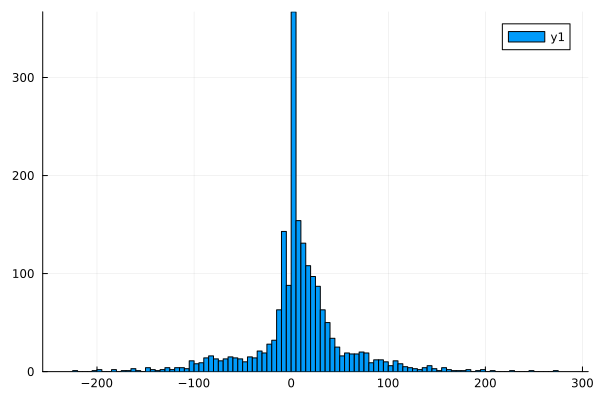

In [109]:
histogram(vec(gs[1].layer_1))

In [52]:
yf_naive

retcode: Success
Interpolation: 1st order linear
t: 101-element Vector{Float64}:
 0.0
 0.01
 0.02
 0.03
 0.04
 0.05
 0.06
 0.07
 0.08
 0.09
 0.1
 0.11
 0.12
 ⋮
 0.89
 0.9
 0.91
 0.92
 0.93
 0.94
 0.95
 0.96
 0.97
 0.98
 0.99
 1.0
u: 101-element Vector{Matrix{ComplexF32}}:
 [0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; … ; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im]
 [0.0007253019f0 + 2.0615002f-5im 0.000732321f0 + 1.999305f-5im … 0.0008406914f0 + 2.4869802f-5im 0.00014856785f0 + 4.063343f-6im; 0.0019366182f0 + 5.4187232f-5im -0.0003864143f0 - 1.0043188f-5im … -0.002622393f0 - 7.17195f-5im 0.00014604986f0 + 5.1650354f-6im; … ; 0.0011028448f0 + 3.1093732f-5im 0.00027130783f0 + 6.9816206f-6im … 0.0010860399f0 + 3.204743f-5im 0.00018370646f0 + 3.9625106f-6im; -0.00050216436f0 - 1.4155343f-5im 0.001400523f0 + 4.180

In [53]:
solution_to_phase(yf_naive, [1.0], spk_args=sa, offset=0.25)[:,:,1]

128×128 Matrix{Float64}:
 -0.150887   -0.263453   -0.16448    …  -0.341213   -0.65403    -0.328503
 -0.0648293  -0.227339   -0.124142      -0.428597   -0.31553    -0.04421
  0.199052   -0.213782   -0.0499857     -0.311867    0.9781      0.540807
 -0.213435    0.721308   -0.552319      -0.925724    0.524224    0.816901
  0.533023   -0.0399132   0.281612       0.156015   -0.211293   -0.109102
  0.730958    0.182551    0.757149   …  -0.0417288   0.604911    0.568831
  0.968157    0.770628    0.830897      -0.768205    0.812946    0.67643
 -0.30656    -0.795896   -0.282842       0.952057   -0.32418    -0.802814
 -0.963323    0.742483    0.904362       0.668521    0.62372     0.781965
 -0.197421    0.410667   -0.263543      -0.482508   -0.174631    0.483096
 -0.110823   -0.264262   -0.163449   …  -0.564565    0.853783    0.758061
 -0.304399   -0.395242   -0.65497        0.512098    0.708588    0.994043
  0.930712    0.75925     0.834625       0.140633    0.770065    0.74396
  ⋮             

In [54]:
(loss_val, st), gs = withgradient(p -> loss(x, x_tms, xl, y, ode_model, p, st, 0.2), psa)

LoadError: Standard interpolation is disabled due to sensitivity analysis being
used for the gradients. Only linear and constant interpolations are
compatible with non-AD sensitivity analysis calculations. Either
utilize tooling like saveat to avoid post-solution interpolation, use
the keyword argument dense=false for linear or constant interpolations,
or use the keyword argument sensealg=SensitivityADPassThrough() to revert
to AD-based derivatives.


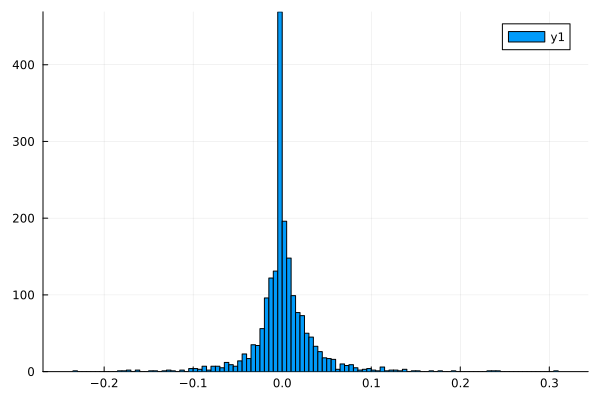

In [ ]:
histogram(gs[1].layer_1 |> vec)

In [42]:
function train(model, ps, st, train_loader, x_tms, threshold::Real = 0.2; id::Int=1, kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    device = cpu

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt_state = Optimisers.setup(Adam(3e-4), ps)
    losses = []
    i = 0

    ## Training
    for epoch in 1:args.epochs
        print("Epoch ", epoch)
        epoch_losses = []
        for (x, xl, y) in train_loader
            (loss_val, st), gs = withgradient(p -> loss(x, x_tms, xl, y, model, p, st, threshold), ps)
            append!(epoch_losses, loss_val)
            opt_state, ps = Optimisers.update(opt_state, ps, gs[1]) ## update parameters
        end
        append!(losses, mean(epoch_losses))
        println(" mean loss ", string(mean(epoch_losses)))
        #filename = joinpath("parameters", "id_") * string(id) * "_epoch_" * string(epoch) * ".jld2"
        #jldsave(filename; params=ps, state=st)
    end

    return losses, ps, st
end

train (generic function with 2 methods)

In [43]:
#loss_history, pst, stt = train(ode_model, psa, st, train_loader, x_tms, 0.2, epochs = 1)

In [44]:
#load params

In [119]:
res = load("trained_nns/ode_id_43_epoch_100.jld2")

Dict{String, Any} with 2 entries:
  "params" => (layer_1 = (layer_1 = (scale = Float32[0.439171, 0.593323, 1.1782…
  "state"  => (layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0,…

In [120]:
pst = res["params"]
stt = res["state"]

(layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()), layer_2 = NamedTuple(), layer_3 = NamedTuple())

In [121]:
loss(x, x_tms, xl, y, ode_model, pst, stt, 0.2)

LoadError: MethodError: no method matching solution_to_phase(::ODESolution{ComplexF32, 3, Vector{Matrix{ComplexF32}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Matrix{ComplexF32}}}, ODEProblem{Matrix{ComplexF32}, Tuple{Float64, Float64}, false, ComponentVector{Float32, SubArray{Float32, 1, Vector{Float32}, Tuple{UnitRange{Int64}}, true}, Tuple{Axis{(layer_1 = ViewAxis(1:28, Axis(scale = 1:14, bias = 15:28)), layer_2 = 29:28, layer_3 = ViewAxis(29:1948, Axis(weight = ViewAxis(1:1792, ShapedAxis((128, 14))), bias = ViewAxis(1793:1920, ShapedAxis((128, 1))))))}}}, ODEFunction{false, SciMLBase.AutoSpecialize, PhasorNetworks.var"#dudt#142"{PhasorODE{Chain{@NamedTuple{layer_1::BatchNorm{true, true, Float32, typeof(identity), typeof(zeros32), typeof(ones32)}, layer_2::WrappedFunction{:direct_call, var"#45#46"}, layer_3::Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}}, Nothing}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, SciMLSensitivity.InterpolatingAdjoint{0, true, Val{:central}, SciMLSensitivity.ZygoteVJP}, Tuple{Float64, Float64}}, var"#41#44"{var"#40#43"{Vector{Float64}, SpikingArgs}, var"#39#42"{Array{Float64, 4}, Vector{Float64}}}, @NamedTuple{layer_1::@NamedTuple{running_mean::Vector{Float32}, running_var::Vector{Float32}, training::Val{true}}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, OrdinaryDiffEq.InterpolationData{ODEFunction{false, SciMLBase.AutoSpecialize, PhasorNetworks.var"#dudt#142"{PhasorODE{Chain{@NamedTuple{layer_1::BatchNorm{true, true, Float32, typeof(identity), typeof(zeros32), typeof(ones32)}, layer_2::WrappedFunction{:direct_call, var"#45#46"}, layer_3::Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}}, Nothing}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, SciMLSensitivity.InterpolatingAdjoint{0, true, Val{:central}, SciMLSensitivity.ZygoteVJP}, Tuple{Float64, Float64}}, var"#41#44"{var"#40#43"{Vector{Float64}, SpikingArgs}, var"#39#42"{Array{Float64, 4}, Vector{Float64}}}, @NamedTuple{layer_1::@NamedTuple{running_mean::Vector{Float32}, running_var::Vector{Float32}, training::Val{true}}, layer_2::@NamedTuple{}, layer_3::@NamedTuple{}}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Vector{Matrix{ComplexF32}}, Vector{Float64}, Vector{Vector{Matrix{ComplexF32}}}, Nothing, OrdinaryDiffEq.Tsit5ConstantCache, Nothing}, SciMLBase.DEStats, Nothing, Nothing, Nothing}, ::Float64; offset::Float64, spk_args::SpikingArgs)

[0mClosest candidates are:
[0m  solution_to_phase(::Union{Function, ODESolution}, [91m::Array[39m; offset, spk_args)
[0m[90m   @[39m [35mPhasorNetworks[39m [90m~/.julia/packages/PhasorNetworks/8rWR9/src/[39m[90m[4mdomains.jl:249[24m[39m


In [48]:
function call_model(model, x, x_tms, xl, ps, st)
    drive_fn = process_inputs(x, x_tms, xl, sa)
    y_pred, _ = model(drive_fn, ps, st)
    return y_pred
end

call_model (generic function with 1 method)

In [49]:
call_fn = (a, b) -> call_model(ode_model, a, x_tms, b, pst, stt)

#54 (generic function with 1 method)

In [86]:
y_front, _ = ode_front(process_inputs(x, x_tms, xl, sa), pst.layer_1, stt.layer_1)

(ODESolution{ComplexF32, 3, Vector{Matrix{ComplexF32}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Matrix{ComplexF32}}}, ODEProblem{Matrix{ComplexF32}, Tuple{Float64, Float64}, false, ComponentVector{Float32, SubArray{Float32, 1, Vector{Float32}, Tuple{UnitRange{Int64}}, true}, Tuple{Axis{(layer_1 = ViewAxis(1:28, Axis(scale = 1:14, bias = 15:28)), layer_2 = 29:28, layer_3 = ViewAxis(29:1948, Axis(weight = ViewAxis(1:1792, ShapedAxis((128, 14))), bias = ViewAxis(1793:1920, ShapedAxis((128, 1))))))}}}, ODEFunction{false, SciMLBase.AutoSpecialize, var"#dudt#56"{PhasorODE{Chain{@NamedTuple{layer_1::BatchNorm{true, true, Float32, typeof(identity), typeof(zeros32), typeof(ones32)}, layer_2::WrappedFunction{:direct_call, var"#45#46"}, layer_3::Dense{true, typeof(identity), typeof(glorot_uniform), typeof(zeros32)}}, Nothing}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, SciMLSensitivity.InterpolatingAdjoint{0, true, Val{:central}

In [50]:
yt, _ = ode_model(process_inputs(x, x_tms, xl, sa), pst, stt)

(Float32[0.0019427626 0.018381698 … 0.004967189 0.009053044; 0.46449655 0.20008944 … 0.1274301 0.27308273; 0.07448383 0.2519717 … 0.48573676 0.1592659], (layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [51]:
yt = call_fn(x, xl)

3×128 Matrix{Float32}:
 0.00194276  0.0183817  -0.00954039  …  0.0303105  0.00496719  0.00905304
 0.464497    0.200089   -0.0146032      0.069447   0.12743     0.273083
 0.0744838   0.251972    0.321946       0.437591   0.485737    0.159266

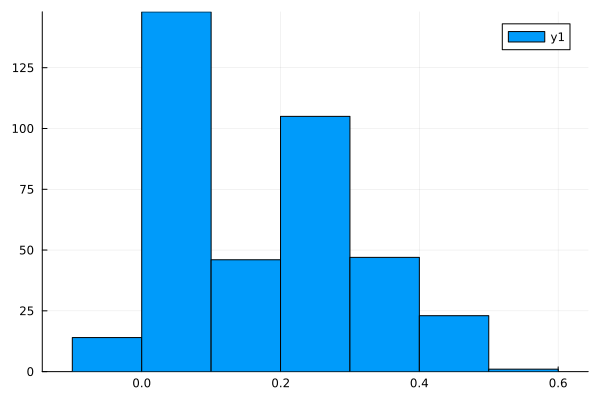

In [52]:
histogram(yt |> vec)

# Make a spiking version

In [116]:
function convert_ode_params(ode_ps)
    # Add a dummy layer of params for the make_spiking layer
    spk_ps = (layer_1 = ode_ps.layer_1, 
            layer_2 = ode_ps.layer_2,
            layer_3 = NamedTuple(),
            layer_4 = ode_ps.layer_3)
    return spk_ps
end

convert_ode_params (generic function with 1 method)

In [117]:
pst_spk = convert_ode_params(pst)

LoadError: UndefVarError: `pst` not defined

In [118]:
stt_spk = convert_ode_params(stt)

LoadError: UndefVarError: `stt` not defined

In [56]:
cycles = 1

1

In [57]:
tspan = (0.0, cycles * sa.t_period)

(0.0, 1.0)

In [58]:
using PhasorNetworks: spiking_offset

In [59]:
spiking_offset(sa)

0.25

In [ ]:
# TODO - revise ODE network to use proper domain conversion method (solution to train, not cmpx to angle)

In [95]:
lastphase = solution_to_phase(y_front, [1.0], offset=0.5, spk_args=sa)

128×128×1 Array{Float64, 3}:
[:, :, 1] =
  0.514466   0.269423    0.461398   …   0.957064    0.267077    0.290764
 -0.620066  -0.623649   -0.601716      -0.627181   -0.691415   -0.679328
  0.229564  -0.432968    0.285198      -0.319865   -0.496879   -0.395769
  0.28814    0.25937     0.332032      -0.207598    0.269399    0.146189
 -0.685545  -0.878588   -0.70885        0.5003     -0.775851   -0.94289
  0.287929   0.328214    0.354963   …   0.0533048   0.208534    0.173746
  0.364168   0.222394    0.374439      -0.292489   -0.0473254   0.206196
  0.635304  -0.864518    0.561269       0.177434    0.420594    0.814589
  0.64019   -0.827678   -0.631725       0.806143    0.768797   -0.946906
  0.976607   0.835261   -0.819447       0.740572    0.495524    0.620771
  0.369516   0.299542    0.382789   …   0.0750064   0.156251    0.259179
 -0.102926  -0.29586    -0.0649847     -0.419307   -0.212782   -0.301831
  0.117868   0.235239    0.307331       0.0115137   0.147518   -0.086582
  ⋮        

In [96]:
angval = complex_to_angle(Array(y_front)[:,:,end])

128×128 Matrix{Float32}:
 -0.514466  -0.269423   -0.461398   …  -0.957064   -0.267077   -0.290764
  0.620066   0.623649    0.601716       0.627181    0.691415    0.679328
 -0.229564   0.432968   -0.285198       0.319865    0.496879    0.395769
 -0.28814   -0.25937    -0.332032       0.207598   -0.269399   -0.146189
  0.685545   0.878588    0.70885       -0.5003      0.775851    0.94289
 -0.287929  -0.328214   -0.354963   …  -0.0533048  -0.208534   -0.173746
 -0.364168  -0.222394   -0.374439       0.292489    0.0473254  -0.206196
 -0.635304   0.864518   -0.561269      -0.177434   -0.420594   -0.814589
 -0.64019    0.827678    0.631725      -0.806143   -0.768797    0.946906
 -0.976607  -0.835261    0.819447      -0.740572   -0.495524   -0.620771
 -0.369516  -0.299542   -0.382789   …  -0.0750064  -0.156251   -0.259179
  0.102926   0.29586     0.0649846      0.419307    0.212782    0.301831
 -0.117868  -0.235239   -0.307331      -0.0115137  -0.147518    0.086582
  ⋮                        

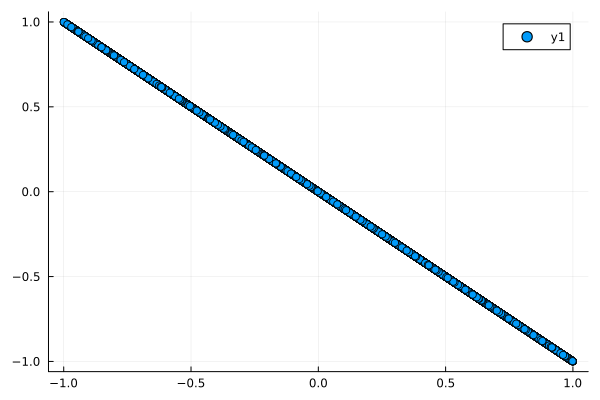

In [97]:
scatter(vec(lastphase), vec(angval))

In [77]:
ode_model_spk = Chain(PhasorODE(ode_fn, tspan=tspan, dt=0.01),
                    x -> solution_to_train(x, tspan, spk_args=sa, offset=0.0),
                    x -> SpikingCall(x, sa, tspan),
                    PhasorDenseF32(128 => 3))

Chain(
    layer_1 = PhasorODE(
        model = Chain(
            layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
            layer_2 = WrappedFunction{:direct_call}(var"#45#46"()),
            layer_3 = Dense(14 => 128),  # 1_920 parameters
        ),
    ),
    layer_2 = WrappedFunction{:direct_call}(var"#57#59"()),
    layer_3 = WrappedFunction{:direct_call}(var"#58#60"()),
    layer_4 = PhasorDenseF32((128, 3)),  # 390 parameters
)         # Total: 2_338 parameters,
          #        plus 29 states.

In [68]:
ode_model_spk = Chain(PhasorODE(ode_fn, tspan=(0.0, 1.0), dt=0.01),)

PhasorODE(
    model = Chain(
        layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
        layer_2 = WrappedFunction{:direct_call}(var"#45#46"()),
        layer_3 = Dense(14 => 128),     # 1_920 parameters
    ),
)         # Total: 1_948 parameters,
          #        plus 29 states.

In [110]:
ode_model_spk = Chain(PhasorODE(ode_fn, tspan=(0.0, 1.0), dt=0.01),
                x -> complex_to_angle(Array(x)[:,:,end]),
                MakeSpiking(sa, repeats),
                PhasorDenseF32(128 => 3))

LoadError: UndefVarError: `repeats` not defined

In [111]:
ps2, st2 = Lux.setup(rng, ode_model_spk)

LoadError: UndefVarError: `ode_model_spk` not defined

In [112]:
ps2.layer_3

LoadError: UndefVarError: `ps2` not defined

In [113]:
#y_spk, _ = ode_model_spk(process_inputs(x, x_tms, xl, sa), pst_spk.layer_1, stt_spk.layer_1)

In [114]:
y_spk, _ = ode_model_spk(process_inputs(x, x_tms, xl, sa), pst_spk, stt_spk)

LoadError: UndefVarError: `pst_spk` not defined

In [115]:
#have to get full output for potential to train??

In [80]:
y_spk

SpikingCall(Spike Train: (3, 128) with 384 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 1.0))

In [83]:
finalv = train_to_phase(y_spk)[end,:,:]

3×128 Matrix{Float64}:
 -0.892648  -0.892648  -0.892648  …  -0.892648  -0.892648  -0.892648
 -0.951043  -0.951043  -0.951043     -0.951043  -0.951043  -0.951043
 -0.863786  -0.863786  -0.863786     -0.863786  -0.863786  -0.863786

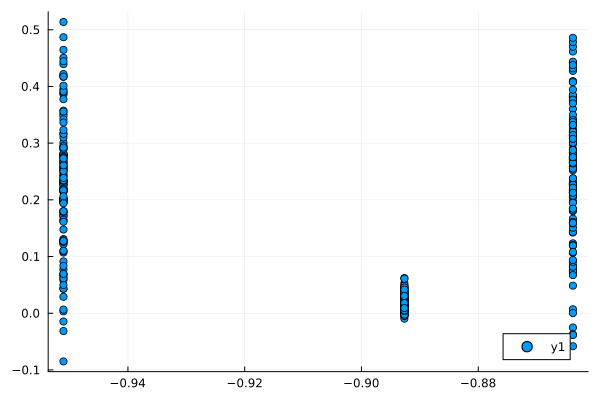

In [84]:
scatter(vec(finalv), vec(yt))

In [ ]:
#TODO - convert to phase and calculate accuracy

# Calculate the Test Loss

In [103]:
xts, xlts, yts = first(test_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [108]:
function accuracy(x, xl, y, model_call::Function, threshold::Real)
    y_truth = get_truth(y, threshold)
    y_pred = model_call(x, xl)
    y_labels = onecold(y_pred, (0, 1, 2))
    right = sum(y_truth .== y_labels)
    return right
end

accuracy (generic function with 2 methods)

In [ ]:
accuracy(xts, xlts, yts, call_fn, 0.2)

85

In [127]:
@time yth = call_fn(q_test[:,:,:,1:10000], ylocal_test[1:10000])

423.714592 seconds (98.05 k allocations: 173.724 GiB, 75.13% gc time, 0.01% compilation time)


3×10000 Matrix{Float32}:
  0.00575107  0.0132568  0.0183644  …  0.0170798   0.0171345   0.0173739
 -0.0206989   0.122195   0.492961      0.0521639  -0.00448545  0.33241
  0.476591    0.385603   0.113538      0.376457    0.470852    0.177874

In [128]:
function accuracy_compare(y_pred, y, threshold::Real)
    y_labels = onecold(y_pred, (0, 1, 2))
    y_truth = get_truth(y, threshold)
    right = sum(y_truth .== y_labels)
    return right
end

accuracy_compare (generic function with 1 method)

In [130]:
accuracy_compare(yth, pt_test[1:10000], 0.2)

7148

In [111]:
function confusion_matrix(prediction, truth, threshold::Real)
    truth = hcat(truth .== 1, truth .== 0)
    prediction = hcat(prediction .> threshold, prediction .<= threshold)

    confusion = truth' * prediction
    return confusion
end

confusion_matrix (generic function with 1 method)

In [112]:
using LinearAlgebra: diag

In [131]:
roc = tpr_fpr(yth, pt_test[1:10000])

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [132]:
roc_fn = interpolate_roc(roc)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    203-element Vector{Float64}:
│     0.0
│     0.0
│     0.0
│     0.0
│     0.0
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/91PhN/src/gridded/gridded.jl:77


203-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [133]:
roc_xs = 0.0:0.01:1.0

0.0:0.01:1.0

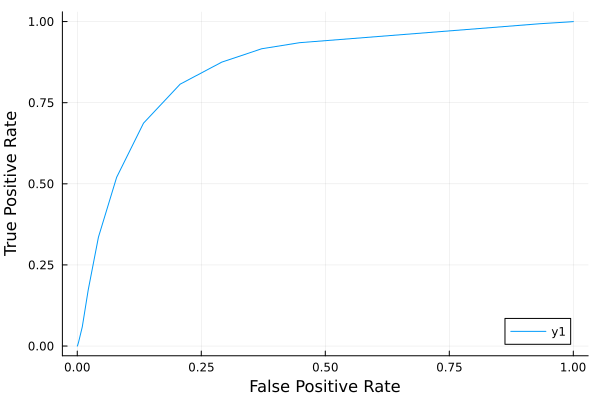

In [134]:
plot(roc[2], roc[1])
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

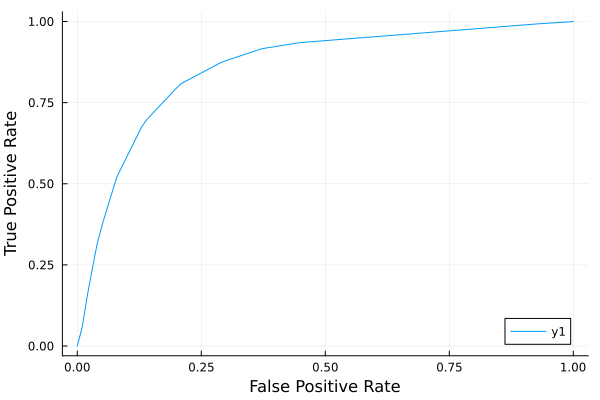

In [135]:
plot(roc_xs, roc_fn.(roc_xs))
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [136]:
auc, _ = quadgk(roc_fn, 0.0, 1.0)

(0.8579861104555654, 1.123425010496124e-8)